In [1]:
# DeepSpeed requires a distributed environment even when only one process is used.
# This emulates a launcher in the notebook
import os

os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [2]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install -q git+https://github.com/huggingface/datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!pip install -q git+https://github.com/huggingface/accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
!pip install -q ipython-autotime

In [6]:
%load_ext autotime

time: 311 µs (started: 2023-08-28 10:17:49 +00:00)


In [7]:
!pip install -q evaluate

time: 4.72 s (started: 2023-08-28 10:17:49 +00:00)


In [8]:
# Standard libraries
import os
import sys
import math

# PyTorch
import torch

# Third-party libraries for data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Libraries for transformers and NLP
import transformers
from transformers import (
    AutoTokenizer,                 # for tokenization
    AutoModelForCausalLM,          # for causal language modeling
    DataCollatorForLanguageModeling, # for data collation
    TrainingArguments,             # for training configurations
    Trainer,                       # for training
    set_seed                       # for reproducibility
)

# Hugging Face Datasets
import datasets
from datasets import load_dataset, Dataset, DatasetDict

# Custom Modules
import evaluate

# Set random seed for reproducibility
set_seed(42)

[2023-08-28 10:17:59,353] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
time: 13.9 s (started: 2023-08-28 10:17:53 +00:00)


In [9]:
library_versions = {
    "Python": sys.version.split()[0],
    "NumPy": np.__version__,
    "Pandas": pd.__version__,
    "Datasets": datasets.__version__,
    "Transformers": transformers.__version__,
    "Torch": torch.__version__,
    "Evaluate": evaluate.__version__,
}

for name, version in library_versions.items():
    print(name.rjust(15), ":", version)

         Python : 3.10.12
          NumPy : 1.23.5
         Pandas : 1.5.3
       Datasets : 2.14.4.dev0
   Transformers : 4.33.0.dev0
          Torch : 2.0.1+cu118
       Evaluate : 0.4.0
time: 1.07 ms (started: 2023-08-28 10:18:07 +00:00)


In [10]:
dataset = load_dataset("NebulaByte/E-Commerce_FAQs")

time: 6.94 s (started: 2023-08-28 10:18:07 +00:00)


In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['parent_category', 'category_id', 'category', 'question_id', 'question', 'answer', 'faq_url', 'que_ans'],
        num_rows: 659
    })
})

time: 2.2 ms (started: 2023-08-28 10:18:14 +00:00)


In [12]:
dataset["train"]

Dataset({
    features: ['parent_category', 'category_id', 'category', 'question_id', 'question', 'answer', 'faq_url', 'que_ans'],
    num_rows: 659
})

time: 2.32 ms (started: 2023-08-28 10:18:14 +00:00)


In [13]:
dataset.set_format("pandas")

time: 718 µs (started: 2023-08-28 10:18:14 +00:00)


In [14]:
df = dataset["train"][:]

time: 9.68 ms (started: 2023-08-28 10:18:14 +00:00)


In [15]:
df

,parent_category,category_id,category,question_id,question,answer,faq_url,que_ans
0,None,55c9cf49b0000024002c1703,Order,55bf40a7d000003d0011ffa1,I missed the delivery of my order today. What ...,The courier service delivering your order usua...,https://www.flipkart.com/helpcentre?catalog=55...,I missed the delivery of my order today. What ...
1,None,55c9cf49b0000024002c1703,Order,55f2a6eb5b00001e003202ed,Will the delivery be tried again if I'm not ab...,Couriers make sure that the delivery is re-att...,https://www.flipkart.com/helpcentre?catalog=55...,Will the delivery be tried again if I'm not ab...
2,None,55c9cf49b0000024002c1703,Order,55f2a6995b00002b003202be,The delivery of my order is delayed. What shou...,On the rare occasion that your order is delaye...,https://www.flipkart.com/helpcentre?catalog=55...,The delivery of my order is delayed. What shou...
3,None,55c9cf49b0000024002c1703,Order,55f2a53f5c00003200342b9c,What should I do if my order is approved but h...,Sellers usually ship orders 1-2 business days ...,https://www.flipkart.com/helpcentre?catalog=55...,What should I do if my order is approved but h...
4,None,55c9cf49b0000024002c1703,Order,55e9455f5a00002500d5e024,Can I take the shipment after opening and chec...,"As per company policy, a shipment can't be ope...",https://www.flipkart.com/helpcentre?catalog=55...,Can I take the shipment after opening and chec...
...,...,...,...,...,...,...,...,...
654,None,5b5edbf548000027009e432b,Flipkart Plus,5d1f24b567000035003926ce,Can I redeem my 'on the way' SuperCoins to ava...,You can redeem 'credited' SuperCoins to avail ...,https://www.flipkart.com/helpcentre?catalog=5b...,Can I redeem my 'on the way' SuperCoins to ava...
655,None,5b5edbf548000027009e432b,Flipkart Plus,5d1f217e6a00001b0027eb1a,Can I redeem SuperCoins to avail discounts for...,"\n\n\nNo, this option is not available at the ...",https://www.flipkart.com/helpcentre?catalog=5b...,Can I redeem SuperCoins to avail discounts for...
656,None,5b5edbf548000027009e432b,Flipkart Plus,5d1f1f376700003600392470,Can I redeem SuperCoins to avail discount for ...,"\n\n\n\n\nNo, this option is not available at ...",https://www.flipkart.com/helpcentre?catalog=5b...,Can I redeem SuperCoins to avail discount for ...
657,None,5b5edbf548000027009e432b,Flipkart Plus,5d1f1b7d67000035003922d6,Can I redeem SuperCoins for Gold and Silver Pr...,"\n\n\nNo, this option is not available at the ...",https://www.flipkart.com/helpcentre?catalog=5b...,Can I redeem SuperCoins for Gold and Silver Pr...


time: 12.2 ms (started: 2023-08-28 10:18:14 +00:00)


In [16]:
df["input"] = "Question: " + df['question'] + " Answer: " + df['answer']

time: 3.7 ms (started: 2023-08-28 10:18:14 +00:00)


In [17]:
# Count the number of words for each 'input'
df['input_word_count'] = df['input'].apply(lambda x: len(str(x).split()))

time: 6.11 ms (started: 2023-08-28 10:18:14 +00:00)


In [18]:
df

,parent_category,category_id,category,question_id,question,answer,faq_url,que_ans,input,input_word_count
0,None,55c9cf49b0000024002c1703,Order,55bf40a7d000003d0011ffa1,I missed the delivery of my order today. What ...,The courier service delivering your order usua...,https://www.flipkart.com/helpcentre?catalog=55...,I missed the delivery of my order today. What ...,Question: I missed the delivery of my order to...,53
1,None,55c9cf49b0000024002c1703,Order,55f2a6eb5b00001e003202ed,Will the delivery be tried again if I'm not ab...,Couriers make sure that the delivery is re-att...,https://www.flipkart.com/helpcentre?catalog=55...,Will the delivery be tried again if I'm not ab...,Question: Will the delivery be tried again if ...,40
2,None,55c9cf49b0000024002c1703,Order,55f2a6995b00002b003202be,The delivery of my order is delayed. What shou...,On the rare occasion that your order is delaye...,https://www.flipkart.com/helpcentre?catalog=55...,The delivery of my order is delayed. What shou...,Question: The delivery of my order is delayed....,50
3,None,55c9cf49b0000024002c1703,Order,55f2a53f5c00003200342b9c,What should I do if my order is approved but h...,Sellers usually ship orders 1-2 business days ...,https://www.flipkart.com/helpcentre?catalog=55...,What should I do if my order is approved but h...,Question: What should I do if my order is appr...,56
4,None,55c9cf49b0000024002c1703,Order,55e9455f5a00002500d5e024,Can I take the shipment after opening and chec...,"As per company policy, a shipment can't be ope...",https://www.flipkart.com/helpcentre?catalog=55...,Can I take the shipment after opening and chec...,Question: Can I take the shipment after openin...,44
...,...,...,...,...,...,...,...,...,...,...
654,None,5b5edbf548000027009e432b,Flipkart Plus,5d1f24b567000035003926ce,Can I redeem my 'on the way' SuperCoins to ava...,You can redeem 'credited' SuperCoins to avail ...,https://www.flipkart.com/helpcentre?catalog=5b...,Can I redeem my 'on the way' SuperCoins to ava...,Question: Can I redeem my 'on the way' SuperCo...,44
655,None,5b5edbf548000027009e432b,Flipkart Plus,5d1f217e6a00001b0027eb1a,Can I redeem SuperCoins to avail discounts for...,"\n\n\nNo, this option is not available at the ...",https://www.flipkart.com/helpcentre?catalog=5b...,Can I redeem SuperCoins to avail discounts for...,Question: Can I redeem SuperCoins to avail dis...,29
656,None,5b5edbf548000027009e432b,Flipkart Plus,5d1f1f376700003600392470,Can I redeem SuperCoins to avail discount for ...,"\n\n\n\n\nNo, this option is not available at ...",https://www.flipkart.com/helpcentre?catalog=5b...,Can I redeem SuperCoins to avail discount for ...,Question: Can I redeem SuperCoins to avail dis...,29
657,None,5b5edbf548000027009e432b,Flipkart Plus,5d1f1b7d67000035003922d6,Can I redeem SuperCoins for Gold and Silver Pr...,"\n\n\nNo, this option is not available at the ...",https://www.flipkart.com/helpcentre?catalog=5b...,Can I redeem SuperCoins for Gold and Silver Pr...,Question: Can I redeem SuperCoins for Gold and...,30


time: 18.2 ms (started: 2023-08-28 10:18:14 +00:00)


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   parent_category   412 non-null    object
 1   category_id       659 non-null    object
 2   category          659 non-null    object
 3   question_id       659 non-null    object
 4   question          659 non-null    object
 5   answer            657 non-null    object
 6   faq_url           659 non-null    object
 7   que_ans           659 non-null    object
 8   input             657 non-null    object
 9   input_word_count  659 non-null    int64 
dtypes: int64(1), object(9)
memory usage: 51.6+ KB
time: 10.2 ms (started: 2023-08-28 10:18:14 +00:00)


In [20]:
df.describe()

,input_word_count
count,659.000000
mean,59.054628
std,39.552052
min,1.000000
25%,39.000000
50%,51.000000
75%,67.500000
max,509.000000


time: 8.96 ms (started: 2023-08-28 10:18:14 +00:00)


The maximum length of this dataset is approximately 509 words.


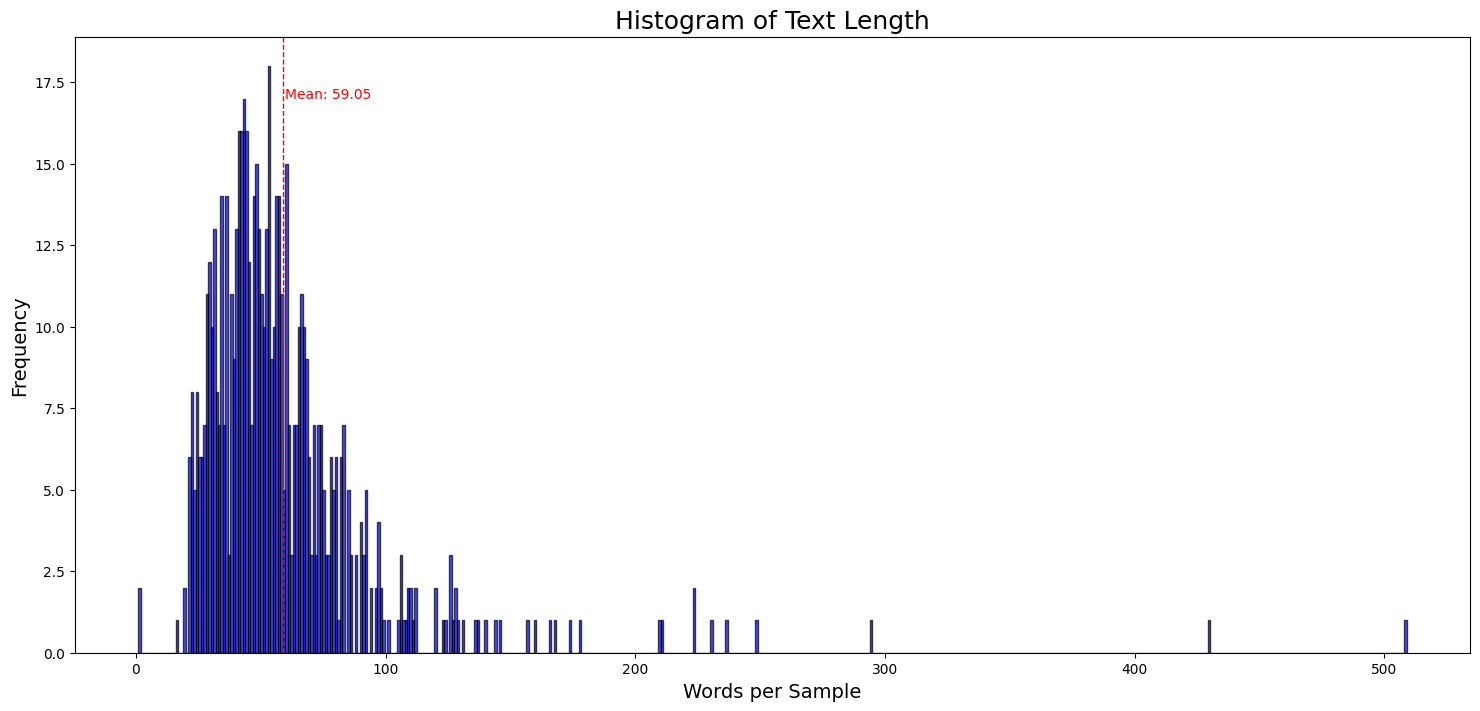

The maximum length of this dataset is approximately 509 words.
time: 913 ms (started: 2023-08-28 10:18:14 +00:00)


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Get the maximum word count
max_word_count = max(df['input_word_count'])

# Calculate the mean word count
mean_word_count = np.mean(df['input_word_count'])

print(f"The maximum length of this dataset is approximately {max_word_count} words.")

# Generate a histogram for word count
plt.figure(figsize=(18, 8))
plt.hist(df['input_word_count'], bins=max_word_count + 1, alpha=0.7, color='blue', edgecolor='black')

# Add a vertical line for the mean word count
plt.axvline(mean_word_count, color='red', linestyle='dashed', linewidth=1)

# Add a text label near the mean line
plt.text(mean_word_count + 0.5, plt.ylim()[1] * 0.9, f'Mean: {mean_word_count:.2f}', color='red')

# Add titles and labels
plt.title('Histogram of Text Length', fontsize=18)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Words per Sample', fontsize=14)

# Show the plot
plt.show()

print(f"The maximum length of this dataset is approximately {max_word_count} words.")


In [22]:
# Calculate the least word count
min_word_count = min(df['input_word_count'])

# Calculate the average word count
average_word_count = np.mean(df['input_word_count'])


print(f"The minimum word count among all entries in this dataset is {min_word_count}.")
print(f"The average word count among all entries in this dataset is {average_word_count:.2f}.")
print(f"The maximum word count among all entries in this dataset is {max_word_count}.")

The minimum word count among all entries in this dataset is 1.
The average word count among all entries in this dataset is 59.05.
The maximum word count among all entries in this dataset is 509.
time: 1.09 ms (started: 2023-08-28 10:18:15 +00:00)


In [23]:
# Sort the DataFrame by the 'input_word_count' column in ascending order
sorted_df = df.sort_values('input_word_count')

# Display the first 100 rows with the least word count
first_hundred_least = sorted_df.head(100)

# To print them out (this may be too much for a console, good for inspection though)
print(first_hundred_least)



       parent_category               category_id  \
280          Insurance  5e8ee62b5100001a000600ec   
281          Insurance  5e8ee62b5100001a000600ec   
168               None  55c9c8e2b0000023002c1702   
337               None  5f295ded4052815c7aef207e   
85                None  55bf48f4d00000490011ffa5   
..                 ...                       ...   
496  Electric Vehicle   6308ea59f86ae76c18b1420d   
236             Others  563ae4ae6f00001e0035fd12   
160            Payment  5d27036a2100002900f9dc20   
556  Electric Vehicle   632bec61a0eaa942e1bed2d9   
80                None  55bf48f4d00000490011ffa5   

                           category               question_id  \
280            Aegon Life Insurance  5e5cf88e49000032000a4465   
281            Aegon Life Insurance  5e5cf8161200001800126269   
168                        Shopping  55bf15e4d00000250011ff90   
337                      SuperCoins  5f75f637eb75572bd79c6260   
85                          Payment  55bb58122c000

In [24]:
df = df[df["input_word_count"] < 250]



time: 1.94 ms (started: 2023-08-28 10:18:15 +00:00)


## Why do we need to drop extremely long sentences?

- Data Imbalance: If dataset has mostly shorter sequences and a few extremely long ones, it could cause the model to train in an unbalanced manner. This may result in poor generalization.

- Influence of Outliers: Extremely long sequences may be outliers that can disproportionately affect the average sequence length, skewing summary statistics and potentially leading to misleading conclusions or poor model performance.

- Training Stability: Long sequences could lead to gradient issues like exploding or vanishing gradients, making the model difficult to train.

In [25]:
df = df[["input"]]
df

,input
0,Question: I missed the delivery of my order to...
1,Question: Will the delivery be tried again if ...
2,Question: The delivery of my order is delayed....
3,Question: What should I do if my order is appr...
4,Question: Can I take the shipment after openin...
...,...
654,Question: Can I redeem my 'on the way' SuperCo...
655,Question: Can I redeem SuperCoins to avail dis...
656,Question: Can I redeem SuperCoins to avail dis...
657,Question: Can I redeem SuperCoins for Gold and...


time: 6.21 ms (started: 2023-08-28 10:18:15 +00:00)


Note: There are two NaN values that are in the input column which we need to drop!

In [26]:
df = df.drop_duplicates()
df = df.dropna()

time: 3.31 ms (started: 2023-08-28 10:18:15 +00:00)


In [27]:
df

,input
0,Question: I missed the delivery of my order to...
1,Question: Will the delivery be tried again if ...
2,Question: The delivery of my order is delayed....
3,Question: What should I do if my order is appr...
4,Question: Can I take the shipment after openin...
...,...
654,Question: Can I redeem my 'on the way' SuperCo...
655,Question: Can I redeem SuperCoins to avail dis...
656,Question: Can I redeem SuperCoins to avail dis...
657,Question: Can I redeem SuperCoins for Gold and...


time: 6.02 ms (started: 2023-08-28 10:18:15 +00:00)


In [28]:
dataset = Dataset.from_pandas(df)

dataset

Dataset({
    features: ['input', '__index_level_0__'],
    num_rows: 654
})

time: 5.28 ms (started: 2023-08-28 10:18:15 +00:00)


In [29]:
dataset = dataset.remove_columns(["__index_level_0__"])


time: 1.49 ms (started: 2023-08-28 10:18:15 +00:00)


In [30]:
dataset

Dataset({
    features: ['input'],
    num_rows: 654
})

time: 2.57 ms (started: 2023-08-28 10:18:15 +00:00)


In [31]:
train_eval_dataset = dataset.train_test_split(test_size=0.20)

ds = DatasetDict({
    'train' : train_eval_dataset["train"],
    'eval' : train_eval_dataset["test"]
})

print('Training data shape:', ds['train'].shape)
print('Eval data shape:', ds['eval'].shape)

Training data shape: (523, 1)
Eval data shape: (131, 1)
time: 7.61 ms (started: 2023-08-28 10:18:15 +00:00)


In [32]:
BLOCK_SIZE = 128
MODEL_CKPT = "microsoft/DialoGPT-large"
BATCH_SIZE = 16
NUM_OF_EPOCHS = 20
STRATEGY = "epoch"

REPORTS_TO = "tensorboard"
LEARNING_RATE = 1e-5

enable_deepseed = True

MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-faqs-block-size-"+f"{BLOCK_SIZE}-bs-{BATCH_SIZE}-lr-{LEARNING_RATE}-deepspeed-{enable_deepseed}"



time: 605 µs (started: 2023-08-28 10:18:15 +00:00)


# Why are we using BLOCK_SIZE even when we've removed extremely lengthy texts?

- This operates at the level of tokenized sequences and serves to standardize the length of sequences for the model's architecture. Even when we've removed extremely lengthy texts, we can still have sequences of varying length after tokenization, and these must be made uniform to feed them into the model. The BLOCK_SIZE parameter helps achieve that uniformity.

In [33]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, padding_side='left', use_fast=True)

def tokenizer_function(samples):
    return tokenizer(samples["input"])

time: 572 ms (started: 2023-08-28 10:18:15 +00:00)


In [34]:
tokenized_ds = ds.map(tokenizer_function,
                      batched=True,
                      remove_columns=ds["train"].column_names,)

tokenized_ds["train"]

Map:   0%|          | 0/523 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1140 > 1024). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 523
})

time: 149 ms (started: 2023-08-28 10:18:16 +00:00)


In [35]:
# Add a new column for token length
def add_token_length(samples):
    samples["token_length"] = len([x for x in samples['input_ids'] if x != 0])  # Ignoring padding
    return samples

# Map add_token_length function
tokenized_ds = tokenized_ds.map(add_token_length)
tokenized_ds

Map:   0%|          | 0/523 [00:00<?, ? examples/s]

Map:   0%|          | 0/131 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'token_length'],
        num_rows: 523
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'token_length'],
        num_rows: 131
    })
})

time: 99.7 ms (started: 2023-08-28 10:18:16 +00:00)


In [36]:
# To see token length of each entry in the 'train' split
for example in tokenized_ds['train']:
    print(example['token_length'])


94
46
81
59
97
115
103
53
49
67
43
58
68
85
57
83
67
77
105
96
35
102
81
41
66
35
58
54
61
207
122
41
52
39
81
34
45
94
45
69
62
178
105
36
49
121
186
110
67
116
61
43
117
40
60
104
75
50
57
45
63
54
39
47
98
68
60
162
56
287
67
34
58
70
74
56
245
59
78
78
144
76
32
52
69
93
51
95
74
207
59
91
88
87
68
40
1140
155
50
70
280
37
72
96
86
34
70
79
38
68
76
153
66
24
134
190
46
42
39
156
84
35
62
76
45
70
77
254
97
95
102
61
86
289
73
82
57
34
110
83
103
69
67
95
107
71
70
49
49
61
162
52
49
50
67
81
72
43
57
190
86
79
65
50
85
37
47
48
36
85
107
110
33
44
119
73
34
52
53
77
58
79
72
32
114
209
42
31
88
67
56
91
89
83
59
74
314
113
57
55
45
121
83
75
130
103
85
28
80
86
66
61
28
54
63
33
73
44
94
44
39
181
48
43
74
61
60
168
31
46
62
88
63
141
90
36
114
75
123
56
79
60
57
59
58
72
79
88
62
50
81
55
47
60
53
101
95
71
108
52
31
68
34
63
122
70
78
98
60
61
73
69
119
83
57
139
64
76
50
56
131
59
90
42
137
44
46
36
48
42
52
54
89
70
68
34
50
80
102
113
36
60
79
42
48
75
58
287
87
81
34
51
58
1

In [37]:
# Create an empty list to store examples
example_list = []

# Collect text, word length, and token length for each entry in 'train' split
for i, example in enumerate(tokenized_ds['train']):
    # Decode tokens back to text string for display
    decoded_text = tokenizer.decode(example['input_ids'])
    # Calculate word length
    word_length = len(decoded_text.split())
    # Get token length
    token_length = example['token_length']

    # Append to the list as a dictionary
    example_list.append({
        'Example': i+1,
        'Text': decoded_text,
        'Word_Length': word_length,
        'Token_Length': token_length
    })

# Sort the list of dictionaries based on Token_Length in descending order
sorted_examples = sorted(example_list, key=lambda x: x['Token_Length'], reverse=True)

# Display sorted examples
for example in sorted_examples:
    print(f"Example {example['Example']}:")
    print(f"Text: {example['Text']}")
    print(f"Word Length: {example['Word_Length']}")
    print(f"Token Length: {example['Token_Length']}")
    print("----------")


Example 97:
Text: Question: What is Flipkart's credit card EMI payment option? Answer: With Flipkart’s credit card EMI option, you can choose to pay in easy installments of 3, 6, 9, 12, 18, or 24 months, with credit cards from the following banks:

HDFC
    
Citi
    
ICICI
    
Kotak
    
Axis
    
Induslnd
    
SBI
    
Standard Chartered
    
HSBC
    

*18 & 24 months EMI options are available from select banks only. Please refer to the table below for more details:




                Banks
            

                Supports 18 & 24 months tenure
            

                Minimum order value to avail 18 & 24 months EMI options
            



                HDFC
            

                Yes
            

                ₹ 10,000
            



                Citi
            

                Yes
            

                ₹ 10,000
            



                ICICI
            

                Yes
            

                ₹ 10,000
            



     

# Observations:
- Minimum Length: The smallest length is 24. If BLOCK_SIZE is set to be less than this, then we'll be truncating some of the text.

- Maximum Length: The largest length is 1140 and model's maximum token size is less than this, we need to truncate or find a way to handle longer sequences.

- Most Common Ranges: The majority of text lengths are well below 200 tokens, with a significant number below 100. This suggests that a smaller block size may be generally sufficient for most entries.

- Memory Efficiency: If we set the BLOCK_SIZE to a high value (like 1024 or 2048), this will consume more memory and may be overkill for the majority of your entries that are much shorter. It might make training inefficient.


Things to consider:
- Statistical Measure: calculate statistical measures like the mean and standard deviation of your token lengths to make an informed choice.

- Iterative Testing: start with a moderate BLOCK_SIZE (maybe around 128 or 256) and see how the model performs.

- Dynamic Adjustment: Some advanced implementations dynamically adjust block size based on the data, although this can complicate the implementation.

Outliers: If only a small percentage of your data is extremely long, you might opt for a smaller BLOCK_SIZE and truncate or specially handle the outliers.

Note: Special characters, white spaces, or newline characters might be getting tokenized separately, thereby increasing the token count.

In [38]:
 tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'token_length'],
        num_rows: 523
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'token_length'],
        num_rows: 131
    })
})

time: 2.04 ms (started: 2023-08-28 10:18:17 +00:00)


In [39]:
# Iterating over each subset (e.g., 'train', 'eval') to remove the 'token_length' column
for subset in tokenized_ds.keys():
    tokenized_ds[subset] = tokenized_ds[subset].remove_columns(['token_length'])

# Now tokenized_ds should no longer have the 'token_length' feature in any of its subsets


time: 3.04 ms (started: 2023-08-28 10:18:17 +00:00)


In [40]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 523
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 131
    })
})

time: 2.13 ms (started: 2023-08-28 10:18:17 +00:00)


Concatenation: Combines tokenized inputs from multiple samples into a single long sequence to allow the model to see more data in a single pass, enabling better understanding of the contextual relationships between different parts of the text.

In [41]:
def group_texts(samples):
    """
    Groups text samples into blocks for training.

    Parameters:
    - samples: A dictionary where the keys are the feature names
               and the values are lists of feature values.

    Returns:
    - result: A dictionary containing features grouped into blocks.
    """

    # Concatenate all text for each feature
    concatenated_examples = {k: sum(samples[k], []) for k in samples.keys()}

    # Determine the total length of the concatenated text for the first feature
    total_length = len(concatenated_examples[list(samples.keys())[0]])

    # Calculate the number of blocks by truncating to the nearest lower multiple of BLOCK_SIZE
    total_length = (total_length // BLOCK_SIZE) * BLOCK_SIZE

    # Log a warning if truncation is happening
    if total_length < len(concatenated_examples[list(samples.keys())[0]]):
        print("Warning: Some tokens are being truncated.")

    # Split each feature into blocks of size BLOCK_SIZE
    result = {
        k: [t[i : i + BLOCK_SIZE] for i in range(0, total_length, BLOCK_SIZE)]
        for k, t in concatenated_examples.items()
    }

    # The labels are a copy of the input_ids for causal language modeling
    result["labels"] = result["input_ids"].copy()

    return result


time: 625 µs (started: 2023-08-28 10:18:17 +00:00)


In [42]:
causal_ds = tokenized_ds.map(
    group_texts,
    batched=True,
    num_proc=2,
)

Map (num_proc=2):   0%|          | 0/523 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/131 [00:00<?, ? examples/s]


time: 495 ms (started: 2023-08-28 10:18:17 +00:00)


In [43]:
model = AutoModelForCausalLM.from_pretrained(MODEL_CKPT)

time: 9.31 s (started: 2023-08-28 10:18:18 +00:00)


In [44]:
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

time: 536 µs (started: 2023-08-28 10:18:27 +00:00)


In [45]:
!pip install -q --upgrade deepspeed

time: 4.82 s (started: 2023-08-28 10:18:27 +00:00)


In [51]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    evaluation_strategy=STRATEGY,
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_OF_EPOCHS,
    report_to=REPORTS_TO,
    deepspeed = "/content/deepspeed_stage1.json",
    hub_private_repo=False,
    push_to_hub=True
)

time: 6.16 ms (started: 2023-08-28 10:23:44 +00:00)


In [47]:
from huggingface_hub import notebook_login
notebook_login()

time: 18.2 ms (started: 2023-08-28 10:18:32 +00:00)


In [52]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=causal_ds["train"],
    eval_dataset=causal_ds["eval"],
    data_collator=data_collator,
)

time: 372 ms (started: 2023-08-28 10:23:53 +00:00)


In [53]:
trainer.train()

Rank: 0 partition count [1, 1] and sizes[(773428480, False), (601600, False)] 


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,4.279446
2,No log,3.573349
3,No log,3.123567
4,No log,2.890314
5,No log,2.739726
6,No log,2.635885
7,No log,2.564321
8,No log,2.517067
9,No log,2.480048
10,No log,2.461150


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1802: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


TrainOutput(global_step=800, training_loss=2.337169609069824, metrics={'train_runtime': 476.0812, 'train_samples_per_second': 13.443, 'train_steps_per_second': 1.68, 'total_flos': 3481880594743296.0, 'train_loss': 2.337169609069824, 'epoch': 20.0})

time: 10min 55s (started: 2023-08-28 10:23:54 +00:00)


In [54]:
evaluation_results = trainer.evaluate()
evaluation_results

{'eval_loss': 2.412252187728882,
 'eval_runtime': 1.1737,
 'eval_samples_per_second': 66.459,
 'eval_steps_per_second': 8.52,
 'epoch': 20.0}

time: 1.18 s (started: 2023-08-28 10:34:49 +00:00)


In [55]:
print(f"Perplexity: {math.exp(evaluation_results['eval_loss']):.2f}")

Perplexity: 11.16
time: 397 µs (started: 2023-08-28 10:34:50 +00:00)


In [56]:
trainer.push_to_hub()

pytorch_model.bin:   0%|          | 0.00/3.35G [00:00<?, ?B/s]

'https://huggingface.co/DrishtiSharma/DialoGPT-large-faqs-block-size-128-bs-16-lr-1e-05-deepspeed-True/tree/main/'

time: 5min 43s (started: 2023-08-28 10:34:51 +00:00)


In [57]:
model.config

GPT2Config {
  "_name_or_path": "microsoft/DialoGPT-large",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1280,
  "n_head": 20,
  "n_inner": null,
  "n_layer": 36,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "conversational": {
      "max_length": 1000
    }
  },
  "torch_dtype": "float32",
  "transformers_version": "4.33.0.dev0",
  "use_cache": true,
  "vocab_size": 50257
}

time: 2.83 ms (started: 2023-08-28 10:40:34 +00:00)


In [58]:
# Access optimizer and scheduler
optimizer = trainer.optimizer
scheduler = trainer.lr_scheduler

print("Optimizer:", optimizer)
print("LR Scheduler:", scheduler)

Optimizer: DeepSpeedOptimizerWrapper (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 1e-05
    lr: 0.0
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 1e-05
    lr: 0.0
    maximize: False
    weight_decay: 0.0
)
LR Scheduler: <torch.optim.lr_scheduler.LambdaLR object at 0x789ff93779d0>
time: 795 µs (started: 2023-08-28 10:40:34 +00:00)
